In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingClassifier
import math
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.transforms

In [2]:
def scoring_gbc_sklearn(X_train, y_train, X_test, y_test, n_estimators=100, 
                        learning_rate=0.5, max_depth=4, random_state=0, max_features=None,
                        min_samples_leaf=1, verbose=True):
    scores_train = []
    scores_test = []
    iterations = []
    weight_0 = 1
    weight_1 = (len(y_train) - y_train.sum())/y_train.sum()
    sample_weights = [weight_1 if i else weight_0 for i in y_train]
    log_iters = list(set((np.logspace(math.log(1, 8), math.log(100, 8), 
                                      num=35, endpoint=True, base=8, 
                                      dtype=np.int))))
    log_iters.sort()
    for i in log_iters:
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=learning_rate, 
                                          max_depth=max_depth, random_state=random_state,
                                          min_samples_leaf=min_samples_leaf, max_features=max_features)
        model.fit(X_train, y_train, sample_weight=sample_weights)
        y_train_pred_scores = model.predict_proba(X_train)
        y_test_pred_scores = model.predict_proba(X_test)
        scores_train.append(roc_auc_score(y_train, y_train_pred_scores[:,1]))
        scores_test.append(roc_auc_score(y_test, y_test_pred_scores[:,1]))
        iterations.append(i)
        
    best_score = max(scores_test)
    best_iter = iterations[scores_test.index(best_score)]
    if verbose:
        print('Best score: {}\nBest iter: {}'.format(best_score, best_iter))
    return scores_train, scores_test, iterations, model

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing

class LabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, drop_invariant=False):
        self.cols = cols
        self.drop_invariant = drop_invariant
        
    def fit(self, X, y=None):
        if self.drop_invariant:
            self.drop = []
            for i in self.cols:
                if len(X[i].unique()) == 1:
                    self.drop.append(i)
            for i in self.drop:
                self.cols.remove(i)
        self.le = []
        for i in self.cols:
            self.le.append(preprocessing.LabelEncoder().fit(X[i]))
        return self   
        
    def transform(self, X):
        if self.drop_invariant:
            X = X.drop(self.drop, axis=1)
        
        for i, j in zip(self.cols, self.le):
            X.loc[:, i+'_le'] = j.transform(X[i])
        X = X.drop(self.cols, axis=1)
        
        return X
    
    def get_feature_names(self):
        return [(i+'_le') for i in self.cols]

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, drop_invariant=False, handle_unknown='value', handle_missing='value'):
        self.cols = cols
        self.drop_invariant = drop_invariant
        self.handle_unknown = handle_unknown
        self.handle_missing = handle_missing
        
    def fit(self, X, y=None):
        if self.drop_invariant:
            self.drop = []
            for i in self.cols:
                if len(X[i].unique()) == 1:
                    self.drop.append(i)
            for i in self.drop:
                self.cols.remove(i)
        self.maps = []
        for i in self.cols:
            self.maps.append(X.groupby(i).size() / len(X))
        return self   
        
    def transform(self, X):
        if self.drop_invariant:
            X = X.drop(self.drop, axis=1)
        
        if self.handle_missing == 'error':
            if X[self.cols].isnull().any().any():
                raise ValueError('Columns to be encoded can not contain null')
        
        for i, j in zip(self.cols, self.maps):
            X.loc[:, i+'_freq'] = X[i].map(j)
        X = X.drop(self.cols, axis=1)
        
        if self.handle_unknown == 'error':
            if X[[(i+'_freq') for i in self.cols]].isnull().any().any():
                raise ValueError('Columns contain unexpected value')
        
        X[[(i+'_freq') for i in self.cols]] = X[[(i+'_freq') for i in self.cols]].fillna(0)
        
        return X
    
    def get_feature_names(self):
        return [(i+'_freq') for i in self.cols]

In [5]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, col, method=None, unknown=None, min_samples = 0, smoothing = 0):
        self.col = col
        self.method = method
        
        if self.method == None:
            self.method = np.mean
        self.unknown = unknown
        self.smoothing = float(smoothing)
        self.min_samples = min_samples
        
    def fit(self, X, y): 
        """
        Параметры
        ----------
        X : Series
            Колонка с обучающими значениями
        y : Series
            Колонка таргета
        """
        col = X[self.col].reset_index(drop=True)
        y = y.reset_index(drop=True)
        
        prior = y.mean()
        name = self.method.__name__
        stats = y.groupby(col).agg(['count', self.method])
        
        if self.smoothing > 0:
            smoove = 1 / (1 + np.exp(-(stats['count'] - self.min_samples) / self.smoothing))
            smoothing = prior * (1 - smoove) + stats[name] * smoove
            smoothing[stats['count'] < self.min_samples] = prior #если меньше min_samples, присваиваем общее среднее
        
        if self.smoothing > 0:
            self.d = smoothing
            return self
        
        self.d = dict(zip(np.unique(col), np.zeros(len(np.unique(col)))))
        for i in np.unique(col):
            if stats['count'][i] < self.min_samples:
                self.d[i] = prior
            else:
                self.d[i] = stats[name][i]
        return self
        return self
    
    def transform(self, X):
        """
        Параметры
        ----------
        X : Series
            Колонка с преобразуемыми значениями
        """
        col = X[self.col]
        answer = np.empty(len(col))
        for k, i in enumerate(X.index):
            if col[i] in self.d.keys():
                answer[k] = self.d[col[i]]
            else:
                if self.unknown == None:
                    answer[k] = np.mean(list(d.values()))
                    #raise Exception("Unexpected value")
                else:
                    answer[k] = self.unknown
        return pd.Series(answer, index=col.index)

In [6]:
from sklearn.utils import check_random_state

class MyTransformerWithTargetMixin:
    def fit_transform(self, X, y=None):
        if y is None:
            raise TypeError('fit_transform() missing argument: ''y''')
        return self.fit(X, y).transform(X, y)

class JamesSteinEncoder(BaseEstimator, MyTransformerWithTargetMixin):
    def __init__(self, cols=None, random_state=None, randomized=False, sigma=0.05):
        self.cols = cols
        self.random_state = random_state
        self.randomized = randomized
        self.sigma = sigma
        self.mapping = {}
        
    def fit(self, X, y): 
        col = X[self.cols].reset_index(drop=True)
        y = y.reset_index(drop=True).astype('float')
        prior = y.mean()
        global_count = len(y)
        global_var = y.var()
        
        for name_col in self.cols:
            stats = y.groupby(col[name_col]).agg(['mean', 'var'])

            i_var = stats['var'].fillna(0) 

            smoothing = i_var / (global_var + i_var) 
            self.mapping[name_col] = (1 - smoothing)*(stats['mean']) + smoothing*prior
        
        return self
    
    
    def transform(self, X, y=None):
        X_now = X.copy()
        for col in self.cols:
            X_now[col] = X_now[col].map(self.mapping[col])
            
            X_now[col].fillna(np.nanmean(X_now[col]), inplace=True)

            if self.randomized and y is not None:
                random_state_generator = check_random_state(self.random_state)
                X_now[col] = (X_now[col] * random_state_generator.normal(1., self.sigma, X_now[col].shape[0]))

        return X_now

In [7]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class WoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col=None, unknown=None):
        self.col = col
        self.unknown = unknown
        
    def fit(self, X, y): 
        col = X[self.col].reset_index(drop=True)
        y = y.reset_index(drop=True)
        
        
        data = pd.DataFrame(pd.concat([col, y], axis=1))
        name = data.columns[1]
        tmp = pd.DataFrame(data.groupby(col)[name].count())[name]
        data = pd.DataFrame(data.groupby(col)[name].sum())
        data['not_target'] = tmp - data[name]
        data['answer'] = np.log((data[name] + 0.5) / (data['not_target'] + 0.5))
        self.d = dict(data['answer'])
        
        return self
    
    def transform(self, X):
        col = X[self.col]
        answer = np.empty(len(col))
        for k, i in enumerate(X.index):
            if col[i] in self.d.keys():
                answer[k] = self.d[col[i]]
            else:
                if self.unknown == None:
                    raise Exception("Unexpected value")
                else:
                    answer[k] = self.unknown
        return pd.Series(answer, index=col.index)

In [8]:
train = pd.read_csv('train.csv')

In [9]:
y = train['target']
train.drop(columns=['id', 'target'], inplace=True)

In [10]:
cols = list(set(train.columns) - set(['ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03']))

In [11]:
def plot_enc(X, y):
    plt.figure(figsize =(8,5))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    js = JamesSteinEncoder(cols=cols, randomized=False, sigma=0.02)
    X_train = js.fit_transform(X_train, y_train)
    X_test = js.transform(X_test)
    print("James Stein encoding:")
    scores_train, scores_test, iterations, model = scoring_gbc_sklearn(X_train, y_train, X_test, y_test)
    plt.plot(iterations, scores_test, label='James Stein encoding')
    
    le = LabelEncoder(cols)
    x = le.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    print("Label encoding:")
    scores_train, scores_test, iterations, model = scoring_gbc_sklearn(X_train, y_train, X_test, y_test)
    plt.plot(iterations, scores_test, label='Label encoding')

    fe = FrequencyEncoder(cols)
    x = fe.fit_transform(X.copy())
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    print("Frequency encoding:")
    scores_train, scores_test, iterations, model = scoring_gbc_sklearn(X_train, y_train, X_test, y_test)
    plt.plot(iterations, scores_test, label='Frequency encoding')
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for i in cols:
        te = TargetEncoder(i, smoothing = 0, unknown=0.2)
        X_train[i] = te.fit_transform(X_train, y_train)
        X_test[i] = te.transform(X_test)
    print("Target encoding, smoothing=0")
    scores_train, scores_test, iterations, model = scoring_gbc_sklearn(X_train, y_train, X_test, y_test)
    plt.plot(iterations, scores_test, label='Target encoding, smoothing=0')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for i in cols:
        te = TargetEncoder(i, smoothing = 1, unknown=0.2)
        X_train[i] = te.fit_transform(X_train, y_train)
        X_test[i] = te.transform(X_test)
    print("Target encoding, smoothing=1:")
    scores_train, scores_test, iterations, model = scoring_gbc_sklearn(X_train, y_train, X_test, y_test)
    plt.plot(iterations, scores_test, label='Target encoding, smoothing=1')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for i in cols:
        te = TargetEncoder(i, smoothing = 2, unknown=0.2)
        X_train[i] = te.fit_transform(X_train, y_train)
        X_test[i] = te.transform(X_test)
    print("Target encoding, smoothing=2:")
    scores_train, scores_test, iterations, model = scoring_gbc_sklearn(X_train, y_train, X_test, y_test)
    plt.plot(iterations, scores_test, label='Target encoding, smoothing=2')
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for i in cols:
        woe = WoEEncoder(i, unknown=-0.7)
        X_train[i] = woe.fit_transform(X_train, y_train)
        X_test[i] = woe.transform(X_test)
    print("WoE encoding:")
    scores_train, scores_test, iterations, model = scoring_gbc_sklearn(X_train, y_train, X_test, y_test)
    plt.plot(iterations, scores_test, label='WoE encoding')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    bbox = matplotlib.transforms.Bbox([[0, 0], [11.2, 5]])
    plt.xlabel('iterations')
    plt.ylabel('roc-auc')
    plt.savefig('drive.pdf', format="pdf", dpi=150, bbox_inches=bbox)

James Stein encoding:
Best score: 0.6327473933536079
Best iter: 10
Label encoding:
Best score: 0.6338185218833231
Best iter: 15
Frequency encoding:
Best score: 0.6320197959991395
Best iter: 17
Target encoding, smoothing=0
Best score: 0.6328280049062868
Best iter: 15
Target encoding, smoothing=1:
Best score: 0.6328280049062868
Best iter: 15
Target encoding, smoothing=2:
Best score: 0.6328280049062868
Best iter: 15
WoE encoding:
Best score: 0.6323044201472654
Best iter: 11


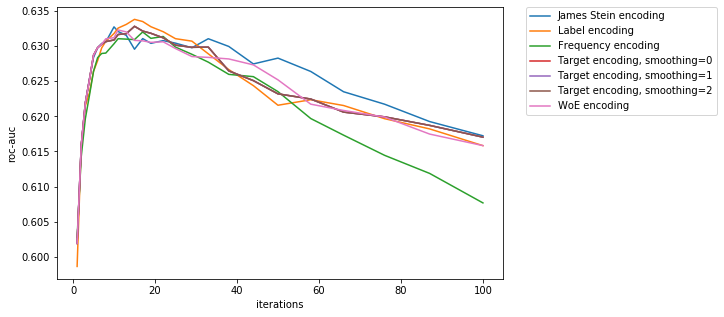

In [12]:
plot_enc(train, y)